In [ ]:
# !nvidia-smi

In [1]:
# !pip install diffusers accelerate transformers opencv-contrib-python

                                              0.0/44.8 MB ? eta -:--:--
                                              0.2/44.8 MB 5.8 MB/s eta 0:00:08
                                              0.4/44.8 MB 4.5 MB/s eta 0:00:10
                                              0.8/44.8 MB 5.7 MB/s eta 0:00:08
     -                                        1.2/44.8 MB 6.8 MB/s eta 0:00:07
     -                                        1.7/44.8 MB 7.3 MB/s eta 0:00:06
     -                                        2.1/44.8 MB 7.8 MB/s eta 0:00:06
     --                                       2.3/44.8 MB 7.6 MB/s eta 0:00:06
     --                                       2.4/44.8 MB 6.7 MB/s eta 0:00:07
     --                                       2.6/44.8 MB 6.5 MB/s eta 0:00:07
     --                                       2.8/44.8 MB 6.4 MB/s eta 0:00:07
     --                                       3.3/44.8 MB 6.5 MB/s eta 0:00:07
     --                                       3.3/44.8 MB 6

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [2]:
import torch
import os
from pathlib import Path
from diffusers.utils import load_image
import numpy as np
import cv2
import PIL

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)

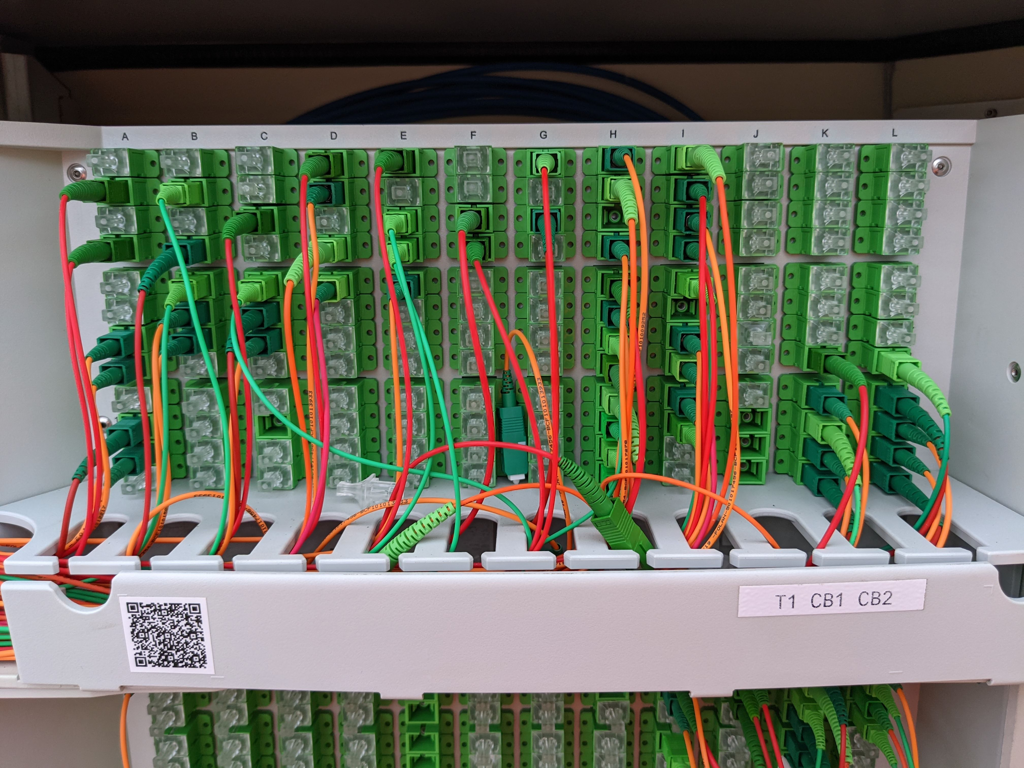

In [3]:
# image = load_image(
#     "https://huggingface.co/lllyasviel/control_v11p_sd15_canny/resolve/main/images/input.png"
# )
image_dir="C:\\Applications\\Projets\\FibreAug\\dataset\\raw_data\\images"
image = PIL.Image.open(os.path.join(image_dir, "000.jpg"))
image = image.resize((1024, 768))
image

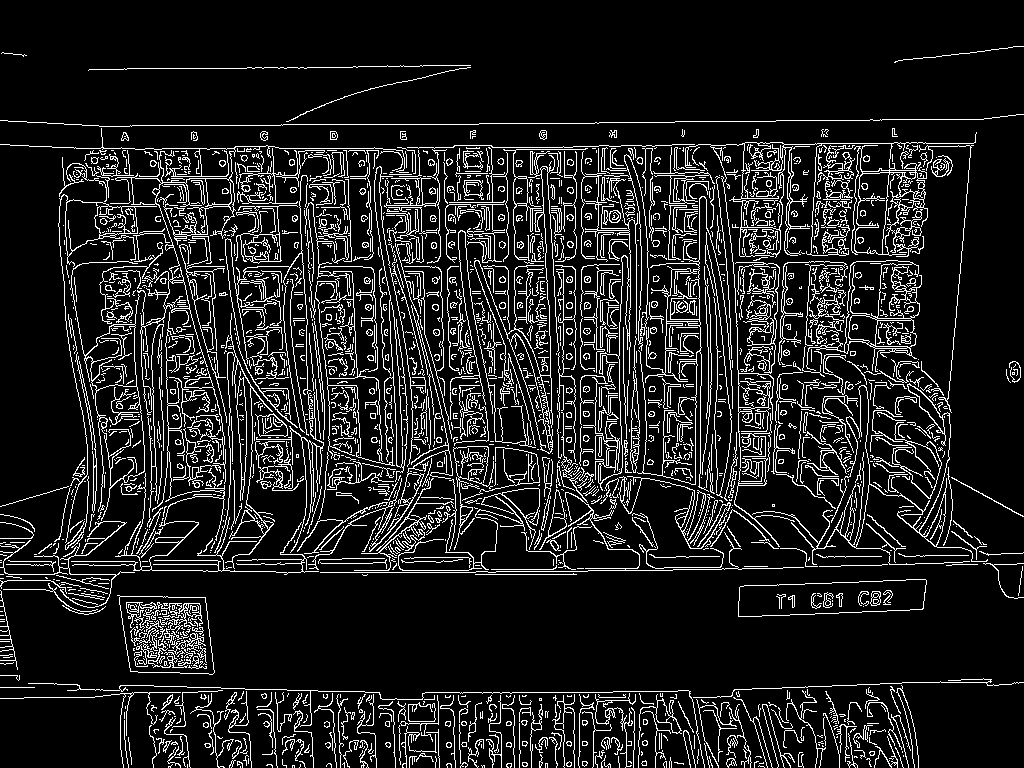

In [4]:
low_threshold = 100
high_threshold = 200

image = np.array(image)
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
control_image = PIL.Image.fromarray(image)
control_image

# control_image.save("./images/control.png")

In [5]:
checkpoint_controlnet = "lllyasviel/control_v11p_sd15_canny"
checkpoint_diffusion = "runwayml/stable-diffusion-v1-5"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


controlnet = ControlNetModel.from_pretrained(checkpoint_controlnet, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    checkpoint_diffusion, controlnet=controlnet, torch_dtype=torch.float16
)
pipe = pipe.to(device)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

prompt = "A cabinet filled with orange, red and white cables, each cable in one color"
generator = torch.manual_seed(33)
image = pipe(prompt, num_inference_steps=20, generator=generator, image=control_image).images[0]
image

# image.save('images/image_out.png')

C:\Users\CZLZ9814\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\CZLZ9814\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


text_encoder\model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx